# Library

In [4]:
# For Clean Tensorflow Verbosity
import os
from silence_tensorflow import silence_tensorflow

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
silence_tensorflow()

# Loading Data
from pandas import read_csv
from pandas import DataFrame

# Manipulation
from numpy import float32
from numpy import reshape
from numpy import hstack
from numpy import zeros
from numpy import sort

# Plotting
from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from seaborn import barplot

# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from tensorflow import tensordot
from tensorflow import nn

from keras.callbacks import Callback # type: ignore
from keras.callbacks import EarlyStopping # type: ignore
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import layers
from keras import Model

# 1. Data Understanding

## 1.1. Downloading Data

Buat folder /data untuk menyimpan dataset

In [2]:
os.makedirs('./data', exist_ok=True)

Mendownload data dari kaggle dan menyimpannya dalam folder data/

In [3]:
!kaggle datasets download CooperUnion/anime-recommendations-database -p data/

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 25.0M/25.0M [00:10<00:00, 2.14MB/s]
100%|██████████████████████████████████████| 25.0M/25.0M [00:10<00:00, 2.44MB/s]


## 1.2. Extracting Data

Mengekstrak data ke dalam folder data/

In [4]:
!unzip data/anime-recommendations-database.zip -d data/

Archive:  data/anime-recommendations-database.zip
  inflating: data/anime.csv          
  inflating: data/rating.csv         


## 1.3. Data Loading

In [5]:
anime_df = read_csv('./data/anime.csv')
rating_df = read_csv('./data/rating.csv')

print("Dataframe Anime")
print("Jumlah Data Anime  :", len(anime_df.anime_id.unique()))

print("\nDataframe Rating")
print("Jumlah Data Rating :", len(rating_df.user_id.unique()))
print("Jumlah Anime yang di rating", len(rating_df.anime_id.unique()))

Dataframe Anime
Jumlah Data Anime  : 12294

Dataframe Rating
Jumlah Data Rating : 73515
Jumlah Anime yang di rating 11200


## 1.5. Anime Variabel

In [6]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
print("Jumlah Anime:", len(anime_df['anime_id'].unique()))

Jumlah Anime: 12294


In [9]:
anime_df['rating'].describe()

count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

## 1.6. Rating Variabel

In [10]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [11]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
print("Jumlah User     :", len(rating_df.user_id.unique()))
print("Jumlah Anime    :", len(rating_df.anime_id.unique()))
print("Panjang Rating  :", len(rating_df.rating.unique()))
print("Rentang Rating  :", sort(rating_df.rating.unique()))

Jumlah User     : 73515


Jumlah Anime    : 11200
Panjang Rating  : 11
Rentang Rating  : [-1  1  2  3  4  5  6  7  8  9 10]


Melihat jumlah data untuk setiap rating

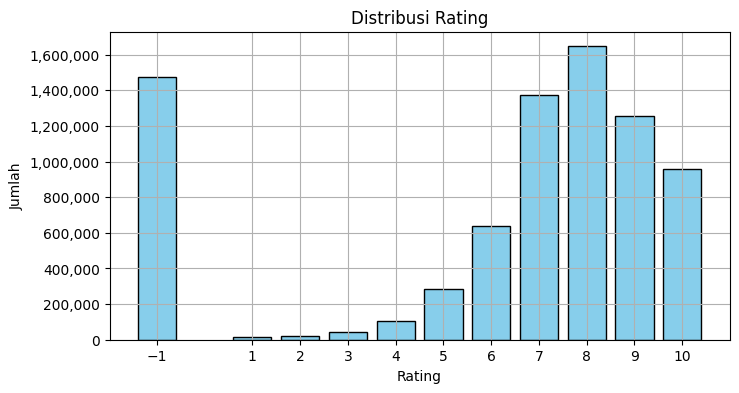

In [13]:
rating_count = rating_df['rating'].value_counts(sort=False)

def y_format(x, pos): return '{:,.0f}'.format(x)
plt.figure(figsize=(8, 4))
plt.bar(rating_count.index, rating_count.values, color='skyblue', edgecolor='black')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.xticks(rating_count.index)
plt.ylabel('Jumlah')
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_format))
plt.grid(True)
plt.show()

Berdasarkan keterangan dataset, nilai rating -1 menandakan anime tersebut sudah ditonton oleh user namun belum mendapatkan rating. Karena data ini tidak dibutuhkan makan akan dihapus pada tahap data preprocessing.

In [14]:
user_rating_count = rating_df.groupby('user_id')['rating'].count()

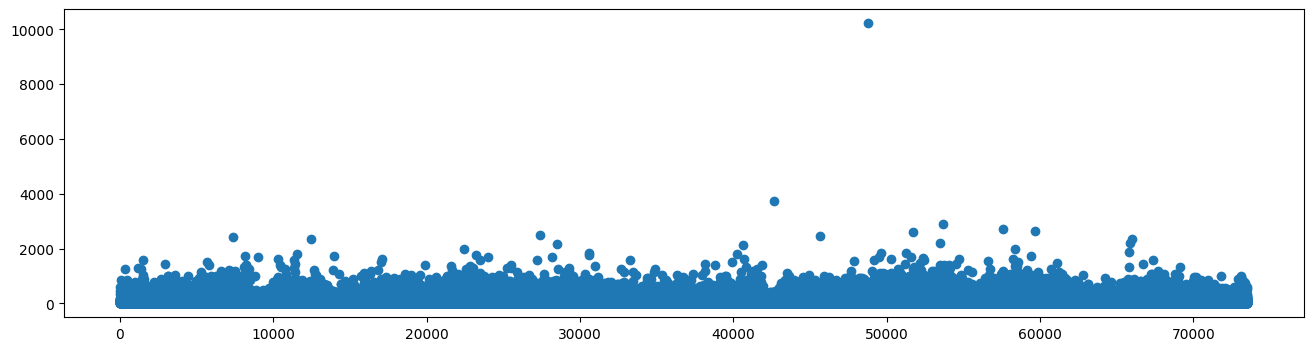

In [15]:
plt.figure(figsize=(16, 4))
plt.scatter(user_rating_count.index, user_rating_count.values)

In [23]:
rating_df.groupby('anime_id')['rating'].count() < 50

anime_id
1        False
5        False
6        False
7        False
8        False
         ...  
34367     True
34412     True
34475     True
34476     True
34519     True
Name: rating, Length: 11200, dtype: bool

In [17]:
anime_rating_count = rating_df[rating_df.groupby('anime_id')['rating'].count() < 50]
anime_rating_count

/tmp/ipykernel_2048/737623655.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anime_rating_count = rating_df[rating_df.groupby('anime_id')['rating'].count() < 50]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

Mencetak informasi statistik deskriptif

In [18]:
rating_df['rating'].describe()

count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

# 2. Data Preprocessing

## 2.1. Missing Value

### 2.1.1. Variabel Anime

In [24]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [26]:
anime_df[anime_df.isnull().any(axis=1)]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


Terdapat 277 data yang memilik missing value. Karena jumlahnya sedikit maka data dengan missing value akan dihapus

In [27]:
anime_df = anime_df.dropna()

# Periksa kembali missing value
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Sekarang dataset anime sudah bersih dari missing value dan jumlah data berkurang menjadi 12017

### 2.1.2. Variabel Rating

In [28]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Tidak terdapat missing value pada dataset rating

## 2.2. Unrated Anime

In [29]:
rating_df = rating_df.loc[rating_df['rating'] != -1]
rating_df.sample(5)

,user_id,anime_id,rating
2099275,20330,1,9
4019592,38114,28171,9
4860697,46369,1887,8
894702,8115,15437,5
4019174,38110,1604,10


In [30]:
rating_df.value_counts(rating_df['rating'], sort=False)

rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: count, dtype: int64

## 2.3. Bias Data

In [31]:
data_anime = anime_df
data_rating = rating_df

### 2.3.1. User

In [35]:
print("User sebelum bias dihapus:", len(data_rating['user_id'].unique()))

user_count_rating = rating_df['user_id'].value_counts()
valid_users = user_count_rating[user_count_rating >= 100]
data_rating = data_rating[data_rating['user_id'].isin(valid_users)]

print("User setelah bias dihapus:", len(data_rating['user_id'].unique()))

User sebelum bias dihapus: 69600
User setelah bias dihapus: 891


### 2.3.2. Anime

In [36]:
data_rating

,user_id,anime_id,rating
8273,100,1281,10
8274,100,6746,10
8275,100,8074,9
8276,100,9919,10
8277,100,11757,10
...,...,...,...
367885,3747,11759,8
367890,3747,14513,9
367891,3747,14741,7
367895,3747,15583,7


In [37]:
data_rating_count = data_rating.groupby('anime_id')['rating'].count()
data_rating_count

anime_id
1        146
5         41
6         91
7         10
8          1
        ... 
33558      9
33569      1
33964      1
34103     10
34240     19
Name: rating, Length: 4579, dtype: int64

In [38]:
data_anime = anime_df.merge(data_rating_count, on='anime_id')
data_anime.rename(columns={'rating_x':'rating', 'rating_y':'num_rating'}, inplace=True)
data_anime

,anime_id,name,genre,type,episodes,rating,members,num_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,18
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,322
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,13
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,275
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,39
...,...,...,...,...,...,...,...,...
4574,3793,Dyogrammaton,Hentai,OVA,2,5.48,1661,1
4575,2592,Kimera,"Action, Horror, Sci-Fi, Supernatural, Vampire,...",OVA,1,5.29,3374,1
4576,5391,Pico to Chico,"Hentai, Yaoi",OVA,1,5.19,29463,10
4577,4866,Pico x CoCo x Chico,"Hentai, Yaoi",OVA,1,5.16,27411,11


In [39]:
data_anime = data_anime[data_anime['num_rating'] > 50]
data_anime

,anime_id,name,genre,type,episodes,rating,members,num_rating
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,322
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,275
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855,113
10,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749,222
12,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888,276
...,...,...,...,...,...,...,...,...
3351,9936,Maken-Ki!,"Action, Ecchi, Harem, Martial Arts, School, Su...",TV,12,6.69,104182,58
3468,4975,ChäoS;HEAd,"Harem, Mystery, Psychological, Sci-Fi, Superna...",TV,12,6.62,174337,71
3651,6682,11eyes,"Action, Ecchi, Super Power, Supernatural",TV,12,6.49,133971,67
3756,15085,Amnesia,"Fantasy, Josei, Mystery, Romance",TV,12,6.39,134349,63


# 3. Data Preparation

## 3.3. Label Encoding

In [40]:
rating_df.sample(10)

,user_id,anime_id,rating
2131594,20637,1122,8
3057656,28326,4981,8
2094785,20290,15689,8
620389,5994,22297,3
6778071,62721,21881,9
3840039,35926,18277,8
4293574,40622,1604,8
4719226,45093,8514,7
6489551,59969,2581,9
7560452,70807,430,9


### 3.3.1. Anime Encoding

In [41]:
userID = data_rating['user_id'].unique().tolist()
idU2idUE = {x : i for i, x in enumerate(userID)}
idUE2idU = {i : x for i, x in enumerate(userID)}

### 3.3.2. Rating Encoding

In [42]:
animeID = data_rating['anime_id'].unique().tolist()
idA2idAE = {x : i for i, x in enumerate(animeID)}
idAE2idA = {i : x for i, x in enumerate(animeID)}

### 3.3.3.Genre Encoding

In [43]:
list_genres = sort(anime_df['genre'].str.split(', ').explode('genre').unique())
num_genre = len(list_genres)
print(num_genre)
print(list_genres)

43
['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']


In [44]:
genre_encode_dict = {genre : i for i, genre in enumerate(list_genres)}
genre_decode_dict = {i : genre for i, genre in enumerate(list_genres)}

In [45]:
def genre_encoding(data):
    return ' '.join([str(genre_encode_dict[genre]) for genre in data.split(', ')])

genre_encoding(anime_df['genre'].loc[0])

'6 25 27 38'

In [46]:
def genre_decoding(data):
    return ' '.join(genre_decode_dict[int(genre)] for genre in data.split())

genre_decoding('6 25 27 38')

'Drama Romance School Supernatural'

### 3.3.4. Mapping to Dataframe

In [47]:
data_rating['user'] = data_rating['user_id'].map(idU2idUE)
data_rating['anime'] = data_rating['anime_id'].map(idA2idAE)

/tmp/ipykernel_2048/4040583601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rating['user'] = data_rating['user_id'].map(idU2idUE)
/tmp/ipykernel_2048/4040583601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rating['anime'] = data_rating['anime_id'].map(idA2idAE)


In [48]:
data_rating

,user_id,anime_id,rating,user,anime
8273,100,1281,10,0,0
8274,100,6746,10,0,1
8275,100,8074,9,0,2
8276,100,9919,10,0,3
8277,100,11757,10,0,4
...,...,...,...,...,...
367885,3747,11759,8,890,97
367890,3747,14513,9,890,579
367891,3747,14741,7,890,102
367895,3747,15583,7,890,172


In [49]:
rating_df.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [50]:
anime_df['genre'] = anime_df['genre'].apply(genre_encoding)

### 3.3.5. Getting Len of User & Anime

In [51]:
num_user = len(idU2idUE)
print("Jumlah User  :", num_user)

num_anime = len(idA2idAE)
print("Jumlah Anime :", num_anime)


Jumlah User  : 891
Jumlah Anime : 4579


### 3.3.6. Convert Rating Values to Float

In [57]:
rating_df['rating'] = rating_df.loc[:, 'rating'].values.astype(float32)

min_rating = min(rating_df['rating'])
print("Rating Terendah:", min_rating)

max_rating = max(rating_df['rating'])
print("Rating Tertinggi:", max_rating)

Rating Terendah: 1.0
Rating Tertinggi: 10.0


## 3.4. Seleksi Fitur

In [58]:
data_rating = data_rating.sample(frac=1, random_state=22)
data_rating

,user_id,anime_id,rating,user,anime
77840,798,4177,8,641,55
27629,317,1530,9,206,331
9881,123,23037,4,23,882
38740,427,11843,8,308,794
61680,640,29976,9,506,1480
...,...,...,...,...,...
84690,884,10396,7,697,375
14520,189,205,10,85,27
35246,392,1482,8,276,273
40675,441,10620,9,321,90


In [59]:
x = data_rating[['user', 'anime']].values
y = data_rating['rating']

print("Dimensi Fitur :", x.shape)
print("Dimensi Label :", y.shape)

Dimensi Fitur : (76645, 2)
Dimensi Label : (76645,)


## 3.5. Normalisasi

In [60]:
scaler = MinMaxScaler()
scaler.fit(reshape(y, (-1, 1)))
y = scaler.fit_transform(reshape(y, (-1, 1)))

## 3.6. Data Splitting

In [61]:
train_indicies = int(0.8 * data_rating.shape[0])
x_train, x_valid, y_train, y_valid = (x[:train_indicies], x[train_indicies:], y[:train_indicies], y[train_indicies:])

print("Dimensi Fitur Latih    :", x_train.shape)
print("Dimensi Label Latih    :", y_train.shape)
print("Dimensi Fitur Validasi :", x_valid.shape)
print("Dimensi Label Validasi :", y_valid.shape)

Dimensi Fitur Latih    : (61316, 2)
Dimensi Label Latih    : (61316, 1)
Dimensi Fitur Validasi : (15329, 2)
Dimensi Label Validasi : (15329, 1)


# 4. Model Development

## 4.1. Content Based Filtering

Menampung dataframe anime ke variabel "data" untuk diolah

In [62]:
data = anime_df

#### 4.1.1. TF-IDF

In [63]:
# Menambahkan [token_pattern=r'\b\w+\b'] agar TFIDF tidak melewati karakter 1 digit
tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
tfidf.fit(data['genre'])
tfidf.get_feature_names_out()

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '5', '6', '7', '8', '9'], dtype=object)

In [64]:
matrix = tfidf.fit_transform(data['genre'])
matrix.shape

(12017, 43)

Menampilkan TFIDF matrix dalam dataframe

In [65]:
DataFrame(matrix.todense(), index=data['name'], columns=[genre_decode_dict[int(x)] for x in tfidf.get_feature_names_out()]).sample(10, axis=1).sample(10, axis=0)

,Magic,Yaoi,School,Fantasy,Josei,Dementia,Action,Music,Shoujo,Kids
name,,,,,,,,,,
Kansen 3: Shuto Houkai,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Tachiguishi Retsuden,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Glass no Kamen Desu ga to Z,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Chinpui: Eri-sama Katsudou Daishashin,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Angel Blade Punish!,0.595225,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Negima!? Natsu Special!?,0.000000,0.0,0.0,0.444002,0.0,0.0,0.000000,0.000000,0.0,0.000000
Chicchana Onaka,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
Yuuwaku Countdown,0.000000,0.0,0.0,0.293603,0.0,0.0,0.270511,0.000000,0.0,0.000000
Dragon Ball Z Movie 14: Kami to Kami,0.000000,0.0,0.0,0.318877,0.0,0.0,0.293797,0.000000,0.0,0.000000


### 4.1.2. Cosine Similarity

In [114]:
# dense output untuk menghemat penggunaan memory/RAM
similarity = cosine_similarity(matrix, dense_output=True)
print(similarity.shape)
similarity

(12017, 12017)


array([[1.        , 0.14692967, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14692967, 1.        , 0.188587  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.188587  , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

Menyimpan cosine similarity matrix ke dalam dataframe similarity_df

In [115]:
similarity_df = DataFrame(similarity, index=data['name'], columns=data['name'])

### 4.1.3. Getting Recommendation

In [116]:
def anime_recommendations(name, similarity_data=similarity_df, items=anime_df[['name', 'genre']], k=5):
    try:
        """
        Provides anime recommendations based on cosine similarity.

        Args:
            name (str): The name of the anime to find recommendations for.
            similarity_data (pd.DataFrame): The similarity matrix DataFrame.
            items (pd.DataFrame): The DataFrame containing anime names and genres.
            k (int): The number of recommendations to return.

        Returns:
            pd.DataFrame: A DataFrame containing the top k recommendations.
        """
        # Get the similarity scores for the given anime
        similarity_scores = similarity_data.loc[:, name]

        # Check if similarity_scores is a DataFrame and convert it to a Series if necessary
        if isinstance(similarity_scores, DataFrame):
            similarity_scores = similarity_scores.iloc[:, 0]

        # Sort the scores in descending order and get the top k indices
        # We add 1 to k to exclude the anime itself from the recommendations
        top_k_indices = similarity_scores.sort_values(ascending=False).index[0:k + 1].drop(name)

        # Get the names of the recommended anime
        closest = top_k_indices

        # Return the recommendations as a DataFrame
        recommendation = DataFrame(closest).merge(items)
        recommendation['genre'] = recommendation['genre'].apply(genre_decoding)

        return recommendation
    
    except KeyError as e:
        print("Tidak ada anime dengan judul serupa di dataset.")
        print("Input judul anime lain atau pastikan judul sudah benar")

anime_recommendations('Death Note', k=10)

,name,genre
0,Death Note Rewrite,Mystery Police Psychological Supernatural Thri...
1,Mousou Dairinin,Drama Mystery Police Psychological Supernatura...
2,Higurashi no Naku Koro ni Kai,Mystery Psychological Supernatural Thriller
3,Higurashi no Naku Koro ni Rei,Comedy Mystery Psychological Supernatural Thri...
4,Mirai Nikki (TV),Action Mystery Psychological Shounen Supernatu...
5,Mirai Nikki (TV): Ura Mirai Nikki,Action Comedy Mystery Psychological Shounen Su...
6,Higurashi no Naku Koro ni,Horror Mystery Psychological Supernatural Thri...
7,Monster,Drama Horror Mystery Police Psychological Sein...
8,AD Police,Adventure Dementia Mecha Mystery Police Psycho...
9,Higurashi no Naku Koro ni Kaku: Outbreak,Horror Mystery Psychological Thriller


## 4.2. Collaborative Filtering

### 4.2.1. Define Model

In [117]:
class RecommenderNet(Model):
    def __init__(self, num_user, num_anime, embedding_size, *args, **kwargs):
        super(RecommenderNet, self).__init__(*args, **kwargs)
        self.num_user = num_user
        self.num_anime = num_anime
        self.embedding_size = embedding_size

        # User Embedding Layer
        self.user_embedding = layers.Embedding(
            num_user,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # User Bias Embedding Layer
        self.user_bias = layers.Embedding(num_user, 1)

        # Anime Embedding Layer
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # Anime Bias Embedding Layer
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 0])
        anime_bias = self.anime_bias(inputs[:, 0])

        dot_matrix = tensordot(user_vector, anime_vector, 2)

        x = dot_matrix + user_bias + anime_bias

        # Activation Layer
        return nn.sigmoid(x)

### 4.2.2. Callback

In [118]:
# class myCallback(Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if (logs.get('root_mean_squared_error') < 0.1 and logs.get('val_root_mean_squared_error') < 0.1):
#             self.model.stop_training=True
#             print('\nMetrix RMSE berhasil mencapai target (RMSE<0.1)')

myCallback = EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=10, restore_best_weights=True)

### 4.2.3. Compile Model

In [127]:
model = RecommenderNet(num_user, num_anime, 50)

model.compile(
    loss = losses.BinaryCrossentropy(),
    optimizer = optimizers.Adam(learning_rate=0.0001),
    metrics = [metrics.RootMeanSquaredError]
)

### 4.2.4. Train Model

In [128]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks=EarlyStopping(monitor='val_root_mean_squared_error', mode='min', patience=5, restore_best_weights=True)
)

Epoch 1/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - loss: 0.6036 - root_mean_squared_error: 0.2321 - val_loss: 0.5425 - val_root_mean_squared_error: 0.1643
Epoch 2/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - loss: 0.5401 - root_mean_squared_error: 0.1611 - val_loss: 0.5377 - val_root_mean_squared_error: 0.1588
Epoch 3/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 0.5366 - root_mean_squared_error: 0.1567 - val_loss: 0.5352 - val_root_mean_squared_error: 0.1560
Epoch 4/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 0.5319 - root_mean_squared_error: 0.1533 - val_loss: 0.5332 - val_root_mean_squared_error: 0.1538
Epoch 5/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.5309 - root_mean_squared_error: 0.1511 - val_loss: 0.5320 - val_root_mean_squared_error: 0.1524
Epoch 6/100
7665/7665 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - loss: 0.5296 - root_mean_squared_error: 0.1496 - val_loss: 0.5315 - val_root_mean_squared_error: 0.1519
Epoch 7/100
7665/7665 ━━━━━━

### 4.2.5. Getting Recommendation

In [246]:
def collaborative_recommendation(userID, k=10):
    # Mengambil sample user
    # user_id_test = data_rating.user_id.sample(1).iloc[0]
    user_id_test = userID
    user_anime_watched = data_rating[data_rating['user_id'] == user_id_test]

    # Membuat list anime yang telah ditonton user
    user_anime_watched

    # Mendapatkan list anime yang belum ditonton user
    # operator ~(bitwise) membalikan nilai boolean
    user_new_anime = data_anime[~data_anime['anime_id'].isin(user_anime_watched.anime_id.values)]['anime_id']
    user_new_anime = list(
        set(user_new_anime).intersection(set(idA2idAE.keys()))
    )

    # Decode anime_id yang ada dalam list anime yang belum ditonton user
    user_new_anime = [[idA2idAE.get(x)] for x in user_new_anime]

    # Decode user id
    user_encoder = idU2idUE.get(user_id_test)

    # Membuat array yang memasangkan user_id dan anime_id yang telah di-encode
    anime_array = hstack(
        ([[user_encoder]] * len(user_new_anime), user_new_anime)
    )

    # Melakukan prediksi rating pada anime baru
    ratings = model.predict(anime_array).flatten()

    # mengurutkan dari nilai terkecil dan mengembalikan index
    # [-10:] => mengambil 10 nilai terakhir
    # [::-1] => reverse urutan dalam array
    top_rating_indicies = ratings.argsort()[-k:][::-1]

    # Decode anime_id yang akan di rekomendasikan
    anime_recommendation_ids = [idAE2idA.get(user_new_anime[x][0]) for x in top_rating_indicies]

    # Cetak List Rekomendasi Anime
    print("\n")
    print("=================================")
    print("=== Your Anime Recommendation ===")
    print("=================================")

    top_user_animes = (
        user_anime_watched.sort_values(
            by = 'rating',
            ascending = False
        )
        .head(5)
        .anime_id.values
    )

    top_anime = data_anime[data_anime['anime_id'].isin(top_user_animes)]
    list_old_title = []
    list_old_genre = []
    for row in top_anime.itertuples():
        print(row.name, '=>', row.genre)
        list_old_title.append(row.name)
        list_old_genre.append(row.genre)
    top_anime_df = DataFrame({'Judul Anime': list_old_title, 'Genre': list_old_genre})
    # top_anime_df

    print("=================================")
    anime_recommendation = data_anime[data_anime['anime_id'].isin(anime_recommendation_ids)]
    list_new_title = []
    list_new_genre = []
    for row in anime_recommendation.itertuples():
        print(row.name, '=>', row.genre)
        list_new_title.append(row.name)
        list_new_genre.append(row.genre)

    recommendations = DataFrame({'Judul Anime': list_new_title, 'Genre': list_new_genre})
    # recommendations

    return top_anime_df, recommendations

In [247]:
top_anime_df, recommendations = collaborative_recommendation(666)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


=== Your Anime Recommendation ===
No Game No Life => Adventure, Comedy, Ecchi, Fantasy, Game, Supernatural
High School DxD New => Action, Comedy, Demons, Ecchi, Harem, Romance, School
Naruto => Action, Comedy, Martial Arts, Shounen, Super Power
High School DxD => Comedy, Demons, Ecchi, Harem, Romance, School
Black Bullet => Action, Mystery, Sci-Fi, Seinen
Mushishi => Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural
Kuroko no Basket 2nd Season => Comedy, School, Shounen, Sports
Akatsuki no Yona => Action, Adventure, Comedy, Fantasy, Romance, Shoujo
Nisekoi => Comedy, Harem, Romance, School, Shounen
Isshuukan Friends. => Comedy, School, Shounen, Slice of Life
Amagami SS => Comedy, Romance, School, Slice of Life
Boku wa Tomodachi ga Sukunai => Comedy, Ecchi, Harem, Romance, School, Seinen, Slice of Life
Maoyuu Maou Yuusha => Adventure, Demons, Fantasy, Historical, Romance
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinob

# 5. Evaluation

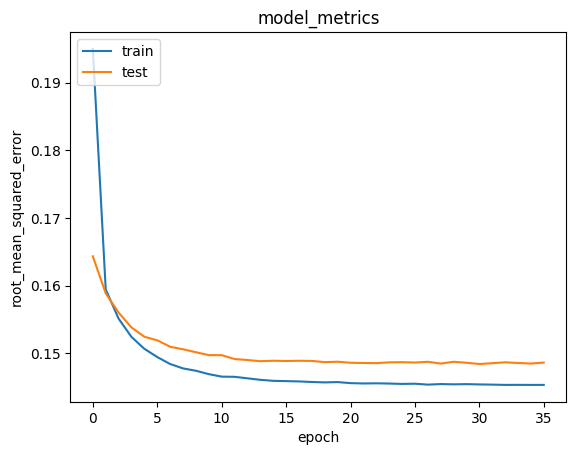

In [129]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()